# Challenge
* Load the houseprices data from Thinkful's database.
* Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
* Now, split your data into train and test sets where 20% of the data resides in the test set.
* Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
* Evaluate your best model on the test set.
* So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

## Load Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Load data from PostgreSQL database and print out
# observations
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices',con=engine)

# No need for an open connection, as we're only doing a single query
engine.dispose()

house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Data Cleaning, Exploratory Data Analysis, and Feature Engineering

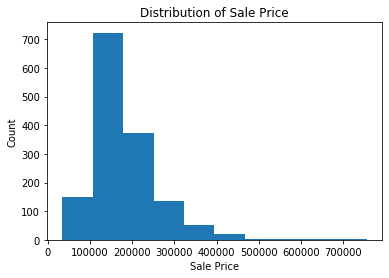

In [2]:
# Look at distribution of target variable: sale price
plt.hist(house_df['saleprice'])
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')

plt.show()

In [3]:
stats.normaltest(house_df['saleprice'])

NormaltestResult(statistic=610.8359109472653, pvalue=2.283848353787728e-133)

The distribution of sale price is skewed to the right (non-normal).

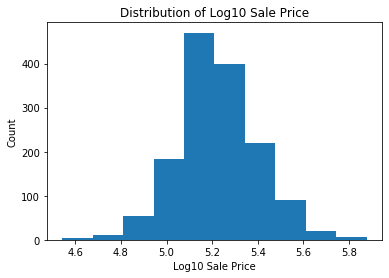

In [4]:
# Transform sale price using np.log10()
house_df['log10_saleprice'] = np.log10(house_df['saleprice'])

# Look at distribution of tranformed target variable
plt.hist(house_df['log10_saleprice'])
plt.title('Distribution of Log10 Sale Price')
plt.xlabel('Log10 Sale Price')
plt.ylabel('Count')

plt.show()

In [5]:
stats.normaltest(house_df['log10_saleprice'])

NormaltestResult(statistic=25.5070098342388, pvalue=2.892165822051631e-06)

The log transformed distribution is still non-normal (p-value less than 0.05), but it is much closer to normal than the non-transformed data. Thus, I will use log10_saleprice as my target variable moving forward.

In [6]:
# Calculate percent missing values
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum() / house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagequal,81,0.055479
garagecond,81,0.055479
garagefinish,81,0.055479
garagetype,81,0.055479


In [7]:
# Drop poolqc, miscfeature, alley, fence, and fireplacequ
# due to high percentage of missing values (greater than 40%)
drop_variables = missing_data.index[missing_data['Percent'] > 0.4]

for i in range(len(drop_variables)):
    house_df.drop(drop_variables[i], axis=1, inplace=True)

house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,log10_saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2,2008,WD,Normal,208500,5.319106
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,5,2007,WD,Normal,181500,5.258877
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,9,2008,WD,Normal,223500,5.349278
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,2,2006,WD,Abnorml,140000,5.146128
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,12,2008,WD,Normal,250000,5.397940


In [8]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
id                 1460 non-null int64
mssubclass         1460 non-null int64
mszoning           1460 non-null object
lotfrontage        1201 non-null float64
lotarea            1460 non-null int64
street             1460 non-null object
lotshape           1460 non-null object
landcontour        1460 non-null object
utilities          1460 non-null object
lotconfig          1460 non-null object
landslope          1460 non-null object
neighborhood       1460 non-null object
condition1         1460 non-null object
condition2         1460 non-null object
bldgtype           1460 non-null object
housestyle         1460 non-null object
overallqual        1460 non-null int64
overallcond        1460 non-null int64
yearbuilt          1460 non-null int64
yearremodadd       1460 non-null int64
roofstyle          1460 non-null object
roofmatl           1460 non-null object
exterior1st        

In [9]:
# Add totalsf variable by summing totalbsmtsf,
# firstflrsf, and secondflrsf
house_df['totalsf'] = house_df['totalbsmtsf'] + house_df['firstflrsf'] + house_df['secondflrsf']

house_df[['totalsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf']].head()

,totalsf,totalbsmtsf,firstflrsf,secondflrsf
0,2566,856,856,854
1,2524,1262,1262,0
2,2706,920,920,866
3,2473,756,961,756
4,3343,1145,1145,1053


In [10]:
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,log10_saleprice,totalsf
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,2,2008,WD,Normal,208500,5.319106,2566
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,5,2007,WD,Normal,181500,5.258877,2524
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,9,2008,WD,Normal,223500,5.349278,2706
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,2,2006,WD,Abnorml,140000,5.146128,2473
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,12,2008,WD,Normal,250000,5.397940,3343


In [11]:
# Create lists of categorical and numerical variables
cat_columns = [col_name for col_name in house_df.dtypes[house_df.dtypes.values == 'object'].index 
               if col_name not in ['id', 'saleprice', 'log10_saleprice']]

num_columns = [col_name for col_name in house_df.dtypes[house_df.dtypes.values == 'int64'].index 
               if col_name not in ['id', 'saleprice', 'log10_saleprice']]

In [12]:
# Number of unique entries for categorical variables
house_df[cat_columns].nunique()

mszoning          5
street            2
lotshape          4
landcontour       4
utilities         2
lotconfig         5
landslope         3
neighborhood     25
condition1        9
condition2        8
bldgtype          5
housestyle        8
roofstyle         6
roofmatl          8
exterior1st      15
exterior2nd      16
masvnrtype        4
exterqual         4
extercond         5
foundation        6
bsmtqual          4
bsmtcond          4
bsmtexposure      4
bsmtfintype1      6
bsmtfintype2      6
heating           6
heatingqc         5
centralair        2
electrical        5
kitchenqual       4
functional        7
garagetype        6
garagefinish      3
garagequal        5
garagecond        5
paveddrive        3
saletype          9
salecondition     6
dtype: int64

In [13]:
# Number of unique entries for numerical variables
house_df[num_columns].nunique()

mssubclass         15
lotarea          1073
overallqual        10
overallcond         9
yearbuilt         112
yearremodadd       61
bsmtfinsf1        637
bsmtfinsf2        144
bsmtunfsf         780
totalbsmtsf       721
firstflrsf        753
secondflrsf       417
lowqualfinsf       24
grlivarea         861
bsmtfullbath        4
bsmthalfbath        3
fullbath            4
halfbath            3
bedroomabvgr        8
kitchenabvgr        4
totrmsabvgrd       12
fireplaces          4
garagecars          5
garagearea        441
wooddecksf        274
openporchsf       202
enclosedporch     120
threessnporch      20
screenporch        76
poolarea            8
miscval            21
mosold             12
yrsold              5
totalsf           963
dtype: int64

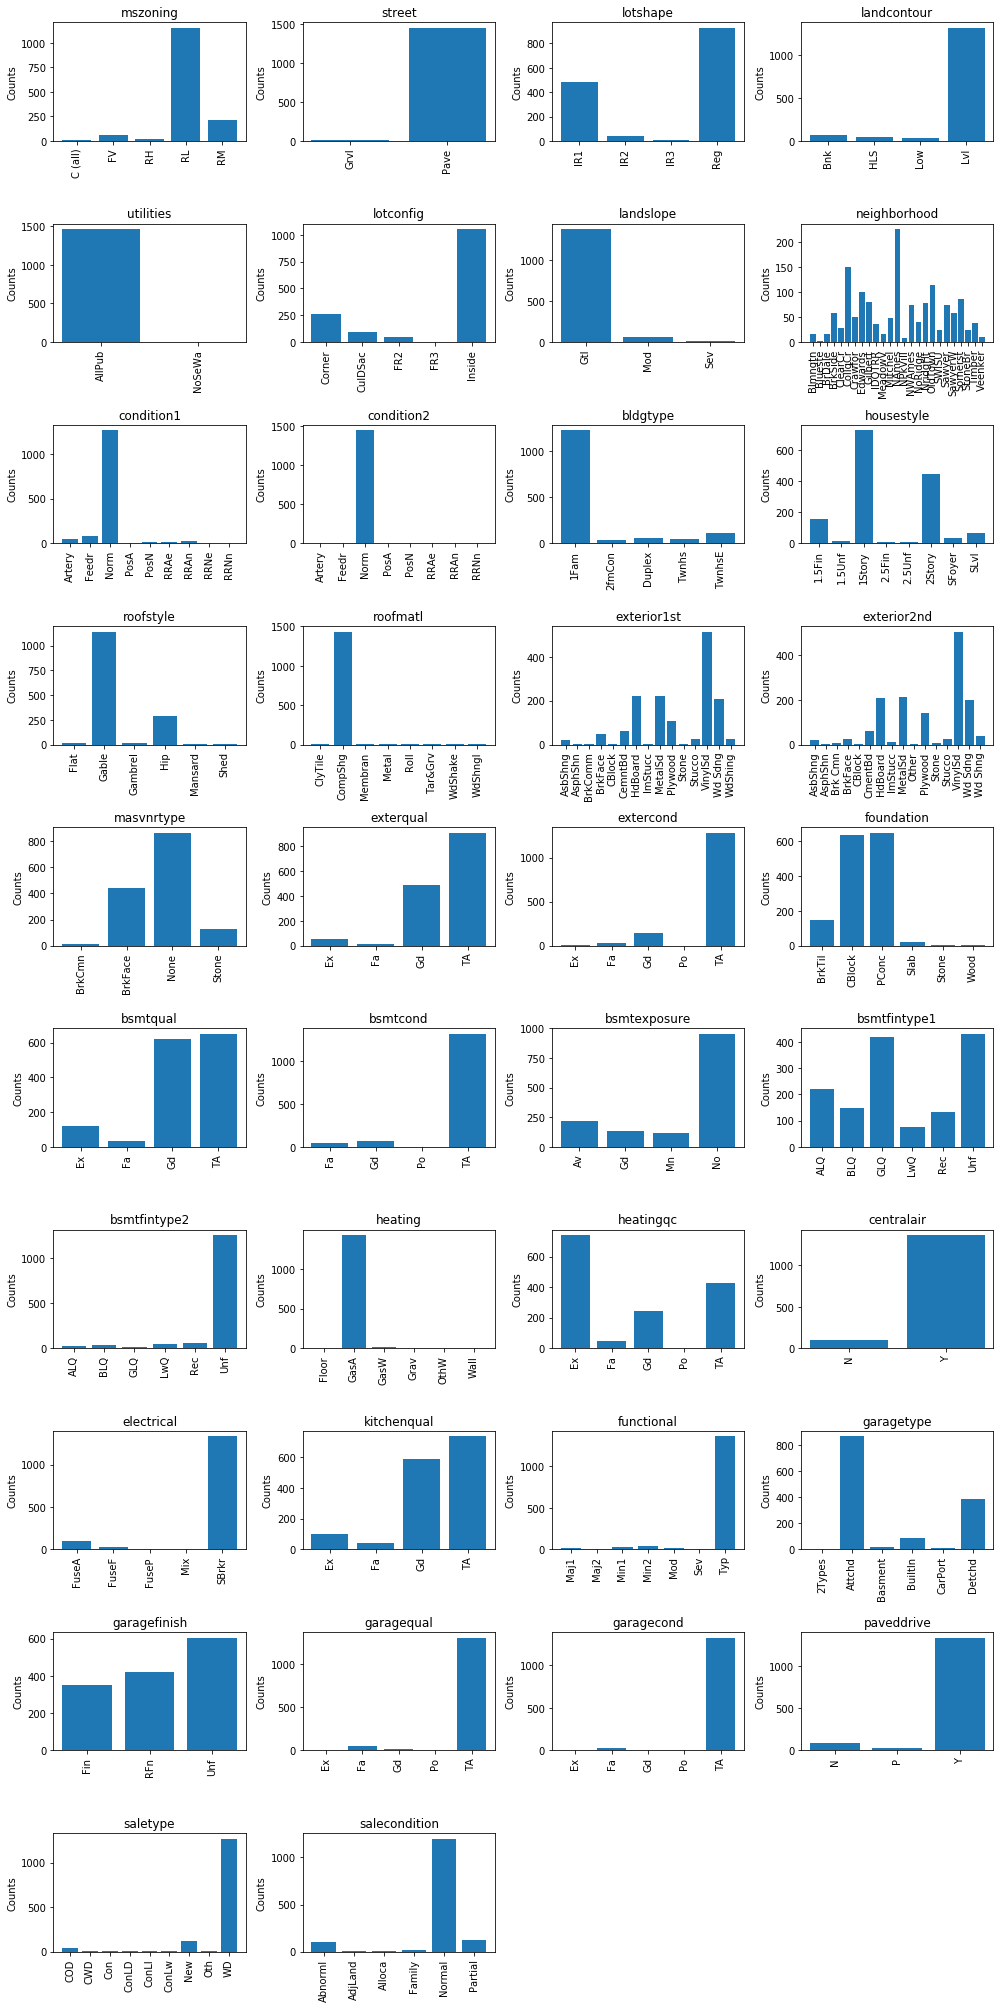

In [14]:
# Look at distributions of categorical variables
# using histograms
plt.figure(figsize=(14, 28))

for i, column in enumerate(cat_columns):
    plt.subplot(10, 4, i + 1)
    plt.bar(house_df.groupby(column)[column].count().index,
           house_df.groupby(column)[column].count())
    plt.title(cat_columns[i])
    plt.ylabel('Counts')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

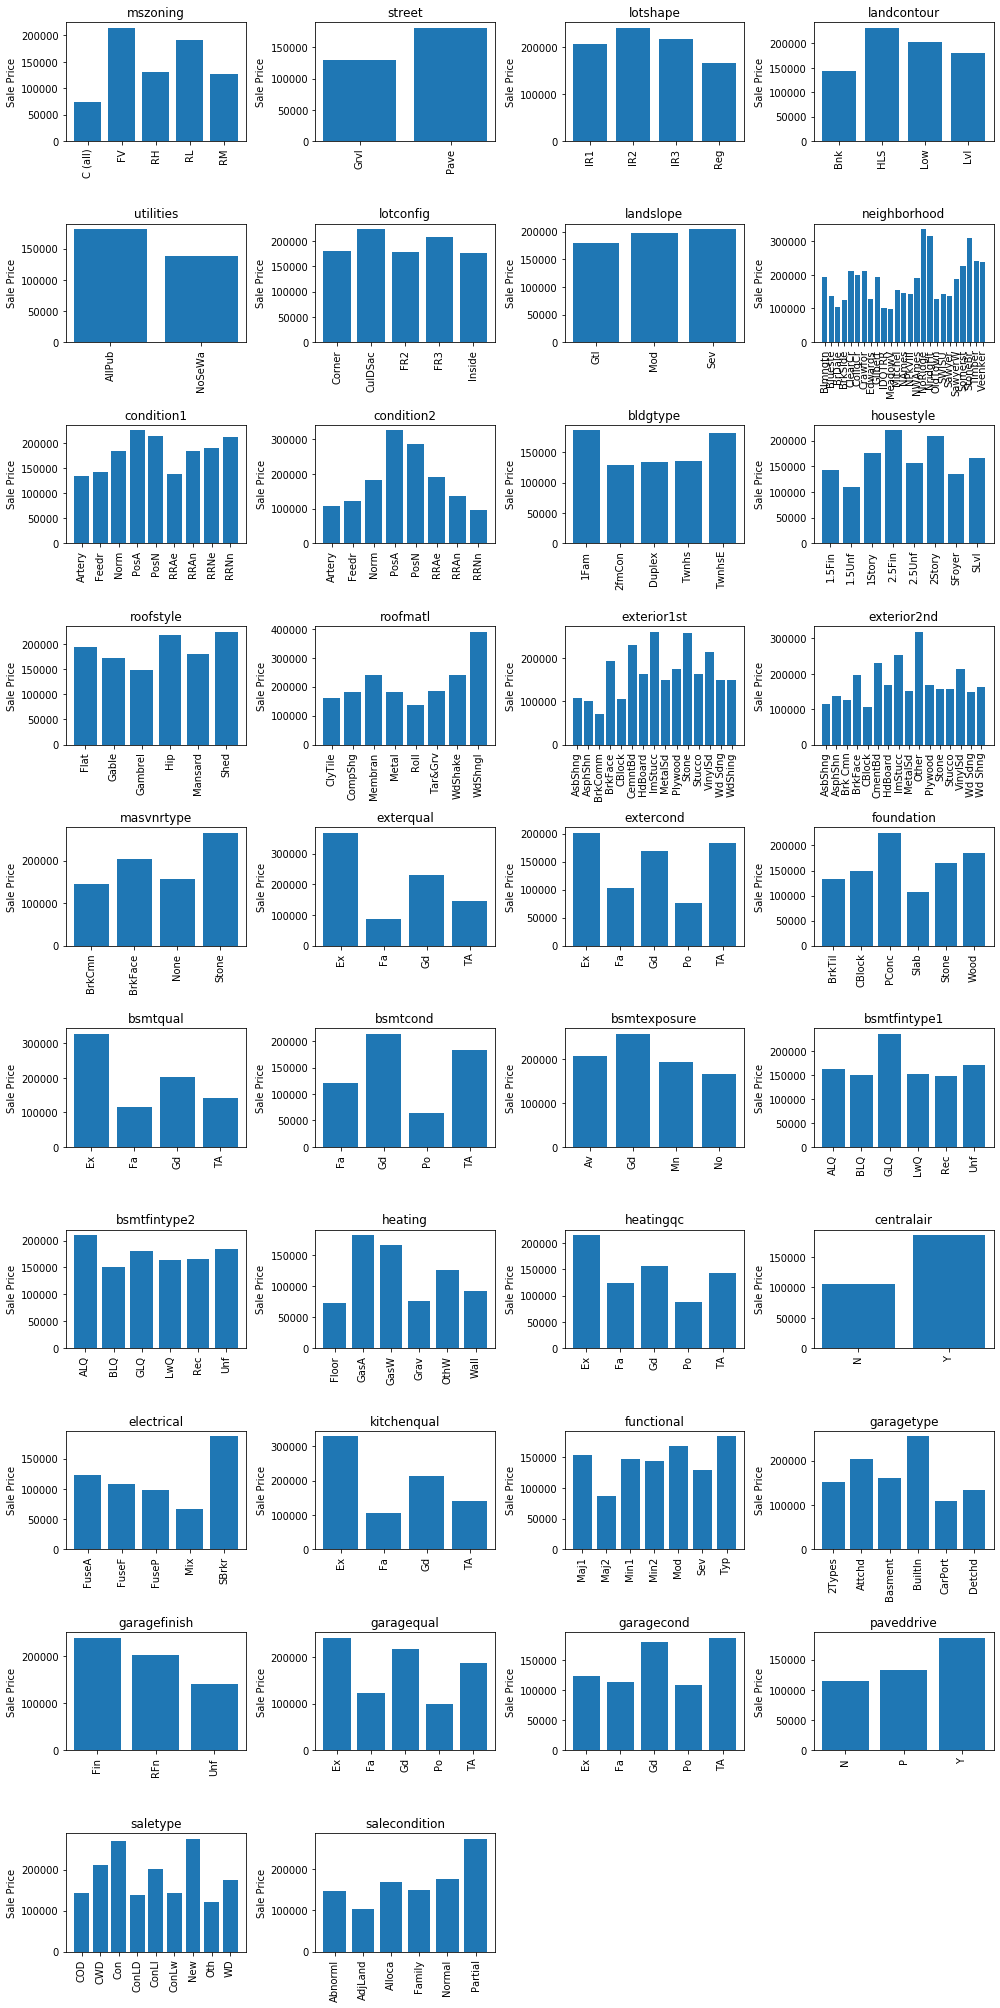

In [15]:
# Look at relationship between log10 sale price
# and categorical variables using barplots
plt.figure(figsize=(14, 28))

for i, column in enumerate(cat_columns):
    plt.subplot(10, 4, i + 1)
    plt.bar(house_df.groupby(column)['saleprice'].mean().index,
            house_df.groupby(column)['saleprice'].mean())
    plt.title(cat_columns[i])
    plt.ylabel('Sale Price')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

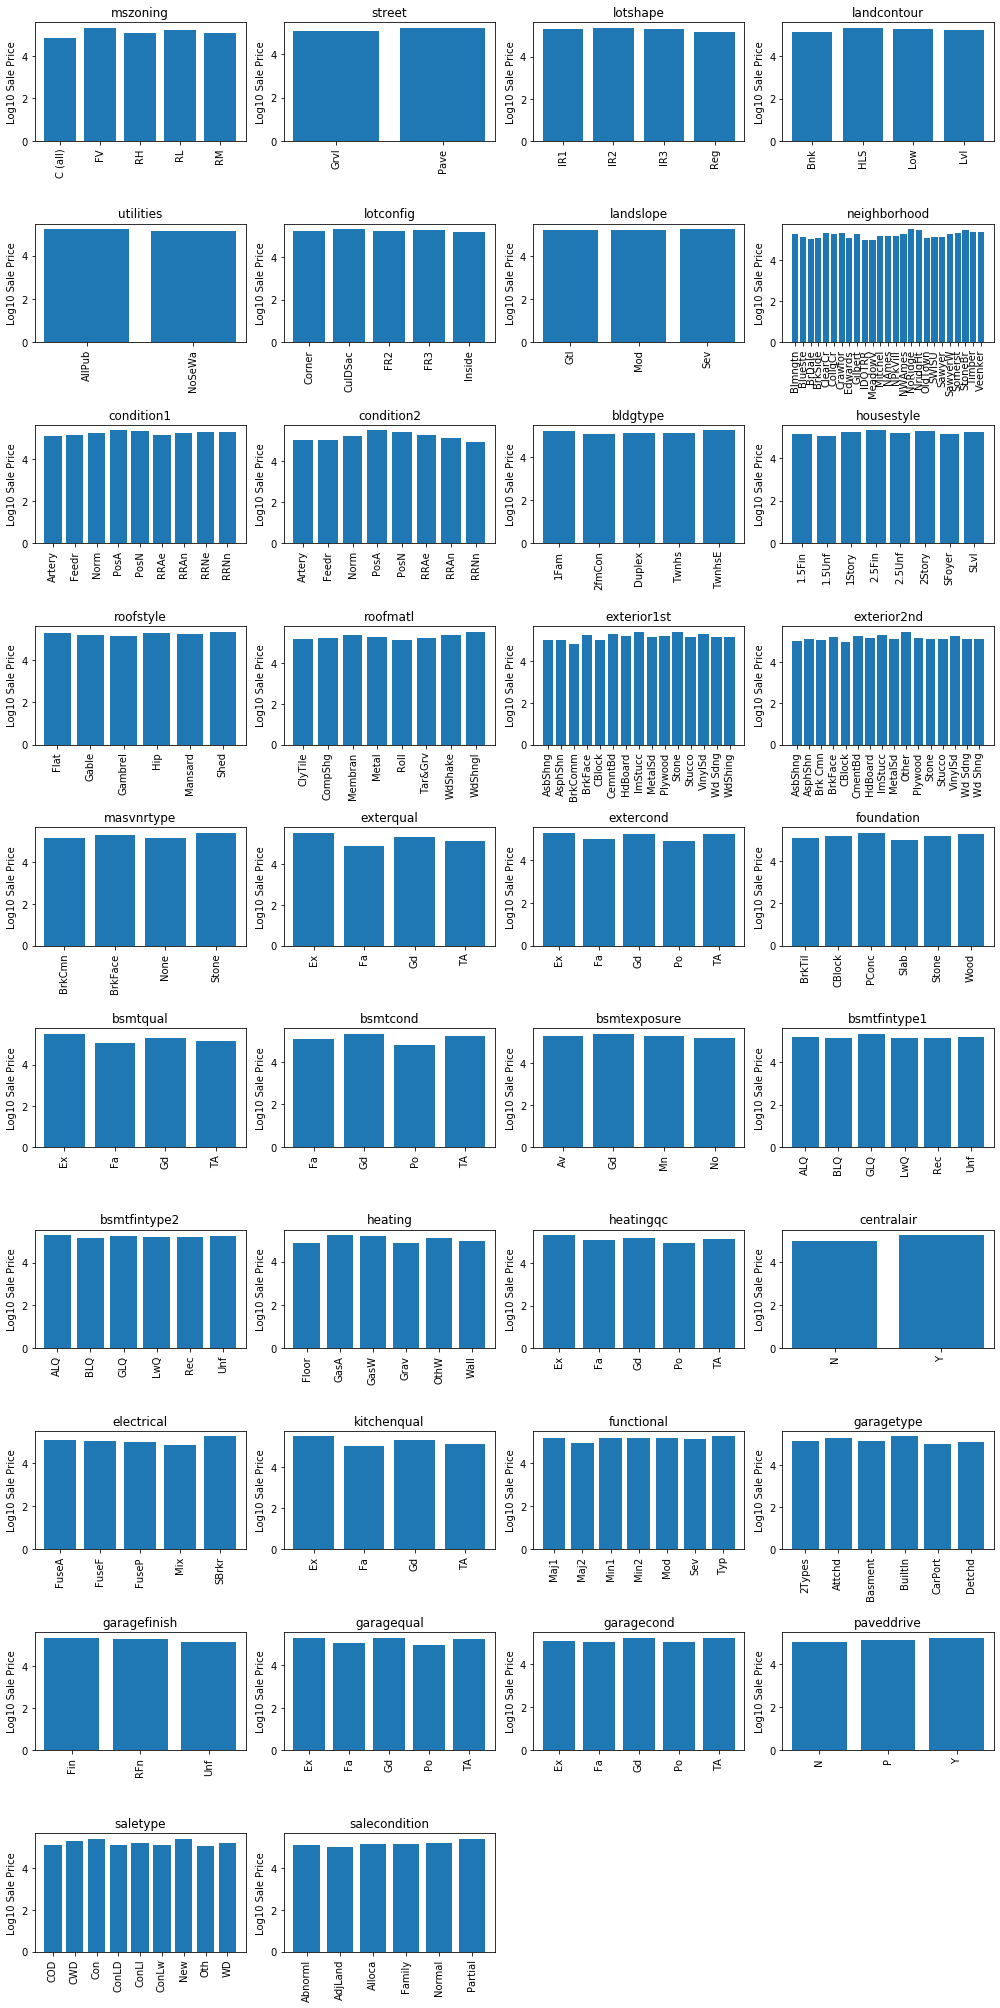

In [16]:
# Look at relationship between log10 sale price
# and categorical variables using barplots
plt.figure(figsize=(14, 28))

for i, column in enumerate(cat_columns):
    plt.subplot(10, 4, i + 1)
    plt.bar(house_df.groupby(column)['log10_saleprice'].mean().index,
            house_df.groupby(column)['log10_saleprice'].mean())
    plt.title(cat_columns[i])
    plt.ylabel('Log10 Sale Price')
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

In [17]:
# Convert neighborhood to numerical variable
house_df['is_nbhd_exp'] = np.where((house_df['neighborhood'] == 'NoRidge') |
                                       (house_df['neighborhood'] == 'NridgHt') | 
                                       (house_df['neighborhood'] == 'StoneBr'), 1, 0)

# Convert bsmtqual to numerical variable
house_df['is_bsmt_ex'] = np.where((house_df['bsmtqual'] == 'Ex'), 1, 0)

# Convert exterqual to numerical variable
house_df['is_exqual_ex'] = np.where((house_df['exterqual'] == 'Ex'), 1, 0)

# Convert kitchenqual to numerical variable
house_df['is_kit_ex'] = np.where((house_df['kitchenqual'] == 'Ex'), 1, 0)

# Convert roofmatl to numerical variable
house_df['is_roof_wdsh'] = np.where((house_df['roofmatl'] == 'WdShngl'), 1, 0)

house_df[['neighborhood', 'is_nbhd_exp', 'bsmtqual', 'is_bsmt_ex',
          'exterqual', 'is_exqual_ex', 'kitchenqual', 'is_kit_ex',
          'roofmatl', 'is_roof_wdsh']].head(50)

,neighborhood,is_nbhd_exp,bsmtqual,is_bsmt_ex,exterqual,is_exqual_ex,kitchenqual,is_kit_ex,roofmatl,is_roof_wdsh
0,CollgCr,0,Gd,0,Gd,0,Gd,0,CompShg,0
1,Veenker,0,Gd,0,TA,0,TA,0,CompShg,0
2,CollgCr,0,Gd,0,Gd,0,Gd,0,CompShg,0
3,Crawfor,0,TA,0,TA,0,Gd,0,CompShg,0
4,NoRidge,1,Gd,0,Gd,0,Gd,0,CompShg,0
5,Mitchel,0,Gd,0,TA,0,TA,0,CompShg,0
6,Somerst,0,Ex,1,Gd,0,Gd,0,CompShg,0
7,NWAmes,0,Gd,0,TA,0,TA,0,CompShg,0
8,OldTown,0,TA,0,TA,0,TA,0,CompShg,0
9,BrkSide,0,TA,0,TA,0,TA,0,CompShg,0


Observation counts across groups differ a lot for most of the categorical variables, which made me a little hesitant to use any of the categorical variables. However, I decided to convert neighborhood, bsmtqual, exterqual, kitchenqual, and roofmatl to numerical variables, so I could test them in my model. These five variables were predictive of homes with higher sale prices, which has been the greatest weakness of my previous house price models.

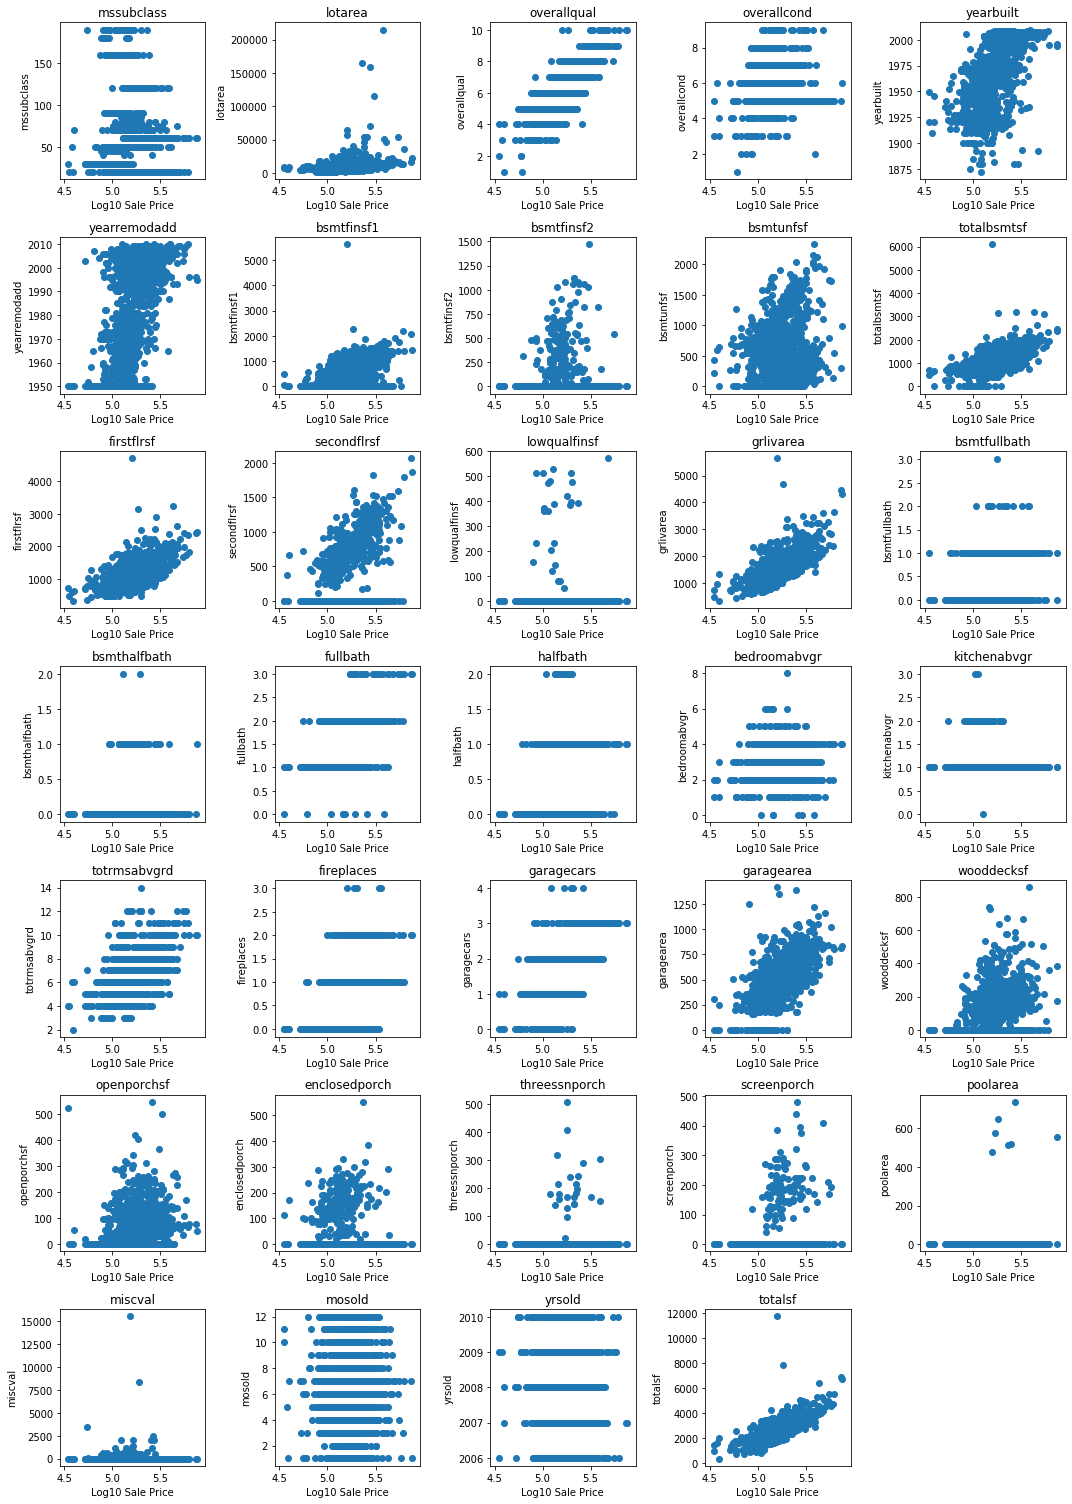

In [18]:
# Look at relationship between log10 sale price
# and remaining numerical variables using barplot
plt.figure(figsize=(15, 21))

for i, column in enumerate(num_columns):
    plt.subplot(7, 5, i + 1)
    plt.scatter(house_df['log10_saleprice'], house_df[column])
    plt.title(num_columns[i])
    plt.xlabel('Log10 Sale Price')
    plt.ylabel(num_columns[i])
    
plt.tight_layout()
plt.show()

In [19]:
# Identify numerical variables that are highly correlated
# with log10 sale price (correlation greater than 0.5)
corrmat = house_df.corr()['log10_saleprice'].sort_values(ascending=False)
high_corrmat = corrmat[abs(corrmat) > 0.5]

final_corrmat = pd.concat([high_corrmat], axis=1, keys=['Correlation'])
final_corrmat

,Correlation
log10_saleprice,1.000000
saleprice,0.948374
overallqual,0.817184
totalsf,0.777296
grlivarea,0.700927
garagecars,0.680625
garagearea,0.650888
totalbsmtsf,0.612134
firstflrsf,0.596981
fullbath,0.594771


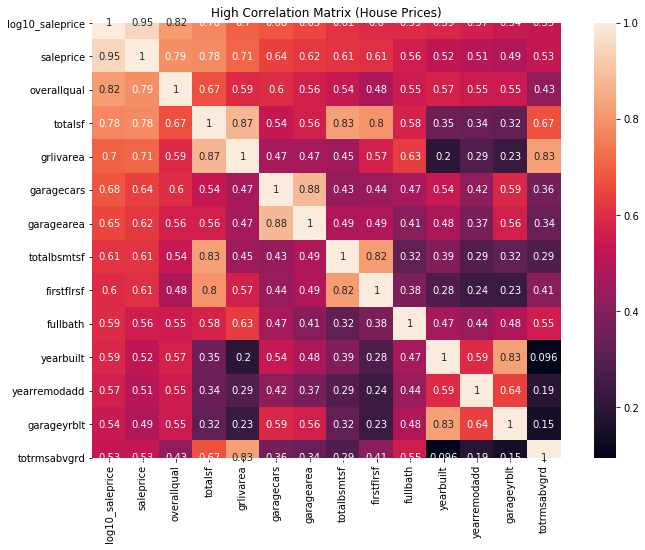

In [20]:
# Use heatmap to look at correlation between
# these variables to eliminate variables with 
# multicollinearity (greater than 0.7)
plt.figure(figsize=(12, 8))

sns.heatmap(house_df[final_corrmat.index].corr(), square=True, annot=True)
plt.title("High Correlation Matrix (House Prices)")

plt.show()

Of the twelve variables correlated with log10 sale price (overallqual, totalsf, grlivarea, garagecars, garagearea, totalbsmtsf, firstflrsf, fullbath, yearbuilt, yearremodadd, garageyrblt, and totrmsabvgrd), I will drop firstflsf, totalbsmtsf, grlivarea, garagearea, and garageyrblt due to multicollinearity.

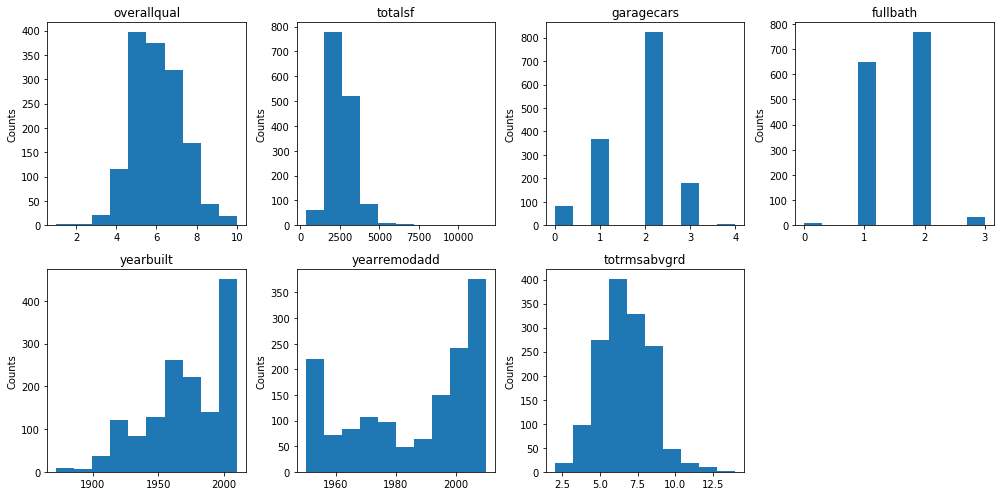

In [21]:
# Look at distribution of remaining numerical variables
plt.figure(figsize=(14, 7))

final_var = ['overallqual', 'totalsf', 'garagecars', 'fullbath', 'yearbuilt', 'yearremodadd', 'totrmsabvgrd']

for i, column in enumerate(final_var):
    plt.subplot(2, 4, i + 1)
    plt.hist(house_df[column])
    plt.title(final_var[i])
    plt.ylabel('Counts')
    
plt.tight_layout()
plt.show()

Based on the correlative data above, as well as these distribution plots, I will use overallqual, totalsf, garagecars, fullbath, yearbuilt, yearremodadd, and totrmsabvgrd as my initial features.

In [22]:
# Add interaction between totalsf and totrmsabvgrd
house_df['sf_int_abvgrd'] = house_df['totalsf'] * house_df['totrmsabvgrd']

# Add interaction between yearbuilt and overallqual
house_df['yr_int_qual'] = house_df['yearbuilt'] * house_df['overallqual']

# Make feature list
feature_list = ['is_kit_ex', 'is_nbhd_exp', 'is_roof_wdsh',
                'is_bsmt_ex', 'is_exqual_ex', 'overallqual',
                'totalsf', 'garagecars', 'fullbath', 'yearbuilt',
                'yearremodadd', 'totrmsabvgrd', 'sf_int_abvgrd', 'yr_int_qual']

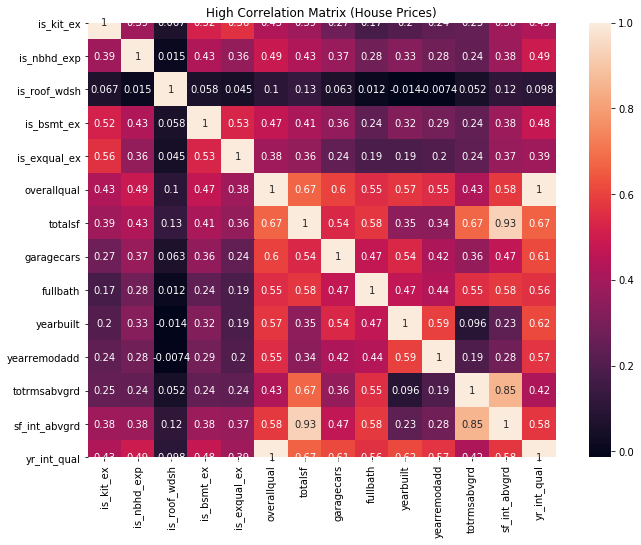

In [23]:
# Use heatmap to look at correlation between
# these variables to eliminate variables with 
# multicollinearity (greater than 0.7)
plt.figure(figsize=(12, 8))

sns.heatmap(house_df[feature_list].corr(), square=True, annot=True)
plt.title("High Correlation Matrix (House Prices)")

plt.show()

None of the added categorical-to-numerical features are highly correlated with my previously chosen numerical features, so I will continue with all 14 features.

## Split Data into Train and Test Sets

In [24]:
# Y is the target variable
Y = house_df['log10_saleprice']

# X is the feature set
X = house_df[feature_list]

# Split data into train and test sets using scikit-learn's
# train_test_split() method. The train_test_split() method
# uses the test_size parameter to decide on how much of the
# data will be split out as test data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


## Build and Evaluate Models

### OLS

In [25]:
# Add a contant to the model, the 'baseline' of
# the data in case all of your feature values are 0
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log10_saleprice   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     445.0
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:49:55   Log-Likelihood:                 1480.4
No. Observations:                1168   AIC:                            -2931.
Df Residuals:                    1153   BIC:                            -2855.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.6875      0.765     -4.822

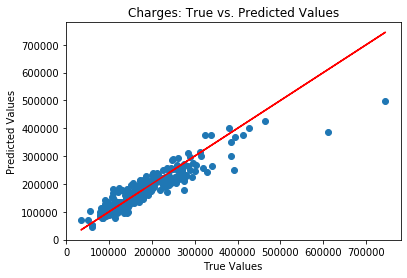

Mean absolute error of the prediction is: 21403.666102476713
Mean squared error of the prediction is: 1119357493.1195862
Root mean squared error of the prediction is: 33456.80040170587
Mean absolute percentage error of the prediction is: 12.116467044630975


In [26]:
# Make predictions by calling the predict() function
# Add constant to the model as it is best practice
X_test = sm.add_constant(X_test)

# Make predictions
y_preds = results.predict(X_test)

plt.scatter(10**y_test, 10**y_preds)
plt.plot(10**y_test, 10**y_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Charges: True vs. Predicted Values')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds) / 10**y_test)) * 100))

### Lasso

In [27]:
# Create list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

lasso_cv = LassoCV(alphas=alphas, cv=5) 
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(lasso_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.8394406598333504

-----Test set statistics-----
R-squared of the model on the test set is: 0.8448476555208387
Mean absolute error of the prediction is: 20866.071082165414
Mean squared error of the prediction is: 1101439775.5851166
Root mean squared error of the prediction is: 33187.9462393369
Mean absolute percentage error of the prediction is: 11.873944340937799


### Ridge

In [28]:
ridge_cv = RidgeCV(alphas=alphas, cv=5) 
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(ridge_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.8438385648080282

-----Test set statistics-----
R-squared of the model on the test set is: 0.8432711863043869
Mean absolute error of the prediction is: 21403.66610197635
Mean squared error of the prediction is: 1119357493.089292
Root mean squared error of the prediction is: 33456.80040125314
Mean absolute percentage error of the prediction is: 12.116467044403063


### ElasticNet

In [29]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5) 
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(elasticnet_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.8394406600880432

-----Test set statistics-----
R-squared of the model on the test set is: 0.8448476555991293
Mean absolute error of the prediction is: 20866.071011514083
Mean squared error of the prediction is: 1101439773.154121
Root mean squared error of the prediction is: 33187.94620271223
Mean absolute percentage error of the prediction is: 11.8739443219485


All four of these models greatly outperform the models I made in previous assignments, with the ElasticNet model performing the best. It explains 84% of the variance in the sale price in both the training and test set with no overfitting (R-squared values are similar between the training and test sets). It also has the lowest MAE, MSE, RMSE, and MAPE values.

## Integrate External Variables into Models

In [31]:
house_df['yrsold'].describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: yrsold, dtype: float64

### Add US Unemployment Rates

In [62]:
# Seasonally adjusted unemployment rates for USA
# from google.com/publicdata (January of each year
# from 2006 to 2010)

house_df['us_unemp'] = pd.Series()

for i, column in enumerate(house_df['yrsold']):
    if column == 2006:
        house_df['us_unemp'][i] = 4.7 
    elif column == 2007:
        house_df['us_unemp'][i] = 4.6
    elif column == 2008:
        house_df['us_unemp'][i] = 5.0
    elif column == 2009:
        house_df['us_unemp'][i] = 7.8
    elif column == 2010:
        house_df['us_unemp'][i] = 9.8
    
house_df[['yrsold', 'us_unemp']]

,yrsold,us_unemp
0,2008,5.0
1,2007,4.6
2,2008,5.0
3,2006,4.7
4,2008,5.0
...,...,...
1455,2007,4.6
1456,2010,9.8
1457,2010,9.8
1458,2010,9.8


### Add US Annual GDP Growth %

In [63]:
# US GDP growth (annual %) from The World Bank
house_df['gdp_growth'] = pd.Series()

for i, column in enumerate(house_df['yrsold']):
    if column == 2006:
        house_df['gdp_growth'][i] = 2.855
    elif column == 2007:
        house_df['gdp_growth'][i] = 1.876
    elif column == 2008:
        house_df['gdp_growth'][i] = -0.137
    elif column == 2009:
        house_df['gdp_growth'][i] = -2.537
    elif column == 2010:
        house_df['gdp_growth'][i] = 2.564
    
house_df[['yrsold', 'gdp_growth']]

,yrsold,gdp_growth
0,2008,-0.137
1,2007,1.876
2,2008,-0.137
3,2006,2.855
4,2008,-0.137
...,...,...
1455,2007,1.876
1456,2010,2.564
1457,2010,2.564
1458,2010,2.564


### Integrate into Models

In [64]:
new_feature_list = ['us_unemp', 'gdp_growth', 'is_kit_ex', 'is_nbhd_exp',
                'is_roof_wdsh', 'is_bsmt_ex', 'is_exqual_ex', 'overallqual',
                'totalsf', 'garagecars', 'fullbath', 'yearbuilt',
                'yearremodadd', 'totrmsabvgrd', 'sf_int_abvgrd', 'yr_int_qual']

# Y is the target variable
Y = house_df['log10_saleprice']

# X is the feature set
X = house_df[new_feature_list]

# Split data into train and test sets using scikit-learn's
# train_test_split() method. The train_test_split() method
# uses the test_size parameter to decide on how much of the
# data will be split out as test data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### OLS

In [65]:
# Add a contant to the model, the 'baseline' of
# the data in case all of your feature values are 0
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log10_saleprice   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     389.2
Date:                Mon, 06 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:32:47   Log-Likelihood:                 1481.0
No. Observations:                1168   AIC:                            -2928.
Df Residuals:                    1151   BIC:                            -2842.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.6776      0.765     -4.806

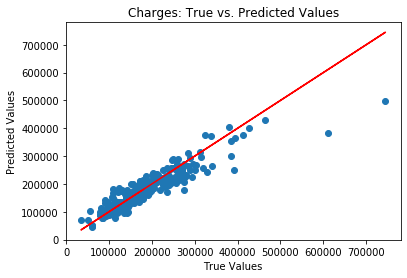

Mean absolute error of the prediction is: 21354.535495328964
Mean squared error of the prediction is: 1115902017.0809717
Root mean squared error of the prediction is: 33405.119623808736
Mean absolute percentage error of the prediction is: 12.087516004438406


In [66]:
# Make predictions by calling the predict() function
# Add constant to the model as it is best practice
X_test = sm.add_constant(X_test)

# Make predictions
y_preds = results.predict(X_test)

plt.scatter(10**y_test, 10**y_preds)
plt.plot(10**y_test, 10**y_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Charges: True vs. Predicted Values')
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds) / 10**y_test)) * 100))

### Lasso

In [67]:
# Create list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

lasso_cv = LassoCV(alphas=alphas, cv=5) 
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(lasso_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.8396374164530872

-----Test set statistics-----
R-squared of the model on the test set is: 0.8459097682042304
Mean absolute error of the prediction is: 20792.970301174955
Mean squared error of the prediction is: 1099317752.864623
Root mean squared error of the prediction is: 33155.96104570976
Mean absolute percentage error of the prediction is: 11.825781591578645


### Ridge

In [68]:
ridge_cv = RidgeCV(alphas=alphas, cv=5) 
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(ridge_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.8440043710239586

-----Test set statistics-----
R-squared of the model on the test set is: 0.844236026362178
Mean absolute error of the prediction is: 21354.535494824573
Mean squared error of the prediction is: 1115902017.0505493
Root mean squared error of the prediction is: 33405.119623353385
Mean absolute percentage error of the prediction is: 12.08751600421215


### ElasticNet

In [69]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5) 
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print('Best alpha value is: {}\n'.format(elasticnet_cv.alpha_))
print("R-squared of the model on the training set is: {}\n".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(10**y_test, 10**y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(10**y_test, 10**y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(10**y_test, 10**y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((10**y_test - 10**y_preds_test) / 10**y_test)) * 100))

Best alpha value is: 1e-10

R-squared of the model on the training set is: 0.839637416710038

-----Test set statistics-----
R-squared of the model on the test set is: 0.8459097684335917
Mean absolute error of the prediction is: 20792.970228267957
Mean squared error of the prediction is: 1099317753.9538825
Root mean squared error of the prediction is: 33155.961062136055
Mean absolute percentage error of the prediction is: 11.825781565736454


Previous Best Model (ElasticNet):
* R-squared of the model on the training set is: 0.8394406600880432
* R-squared of the model on the test set is: 0.8448476555991293
* Mean absolute error of the prediction is: 20866.071011514083
* Mean squared error of the prediction is: 1101439773.154121
* Root mean squared error of the prediction is: 33187.94620271223
* Mean absolute percentage error of the prediction is: 11.8739443219485

Best Model using External Variables (ElasticNet):
* R-squared of the model on the training set is: 0.839637416710038
* R-squared of the model on the test set is: 0.8459097684335917
* Mean absolute error of the prediction is: 20792.970228267957
* Mean squared error of the prediction is: 1099317753.9538825
* Root mean squared error of the prediction is: 33155.961062136055
* Mean absolute percentage error of the prediction is: 11.825781565736454

The addition of US Annual GDP Growth % and US Unemployment Rates at the time the house sold had a very small yet positive impact on the predictive performance of my model, as demonstrated by slight increases in R-squared values and slight decreases in MAE, MSE, RMSE, and MAPE values.